# Gaia EDR3 + 2MASS Query

Reproducing the query from `low_parallax_query_2mass_ebv.pro` using sqlutil to get low parallax stars with 2MASS photometry and extinction data.

In [22]:
import numpy as np
import sqlutilpy as sqlutil
import matplotlib.pyplot as plt
import astropy.table as atpy
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import os
from astropy.io import fits

In [ ]:
# Query from low_parallax_query_2mass_ebv.pro
# Original IDL query:
# 'SELECT gs.source_id, xm.ra,xm.dec,xm.j_m,xm.h_m,xm.k_m,gs.ebv,xm.pmra,xm.pmdec,xm.pmra_error,xm.pmdec_error,xm.phot_g_mean_mag,xm.bp_rp,xm.parallax,xm.parallax_error,xm.phot_bp_rp_excess_factor,xm.phot_g_n_obs FROM gaia_edr3_aux.gaia_source_2mass_xm as xm, gaia_edr3.gaia_source as gs where xm.source_id=gs.source_id and xm.parallax <0.5 AND abs(xm.b) > 5 and xm.pmra^2+xm.pmdec^2 < 25;'

query = """
SELECT gs.source_id, 
       xm.ra, xm.dec, xm.j_m, xm.h_m, xm.k_m, 
       gs.ebv, 
       xm.pmra, xm.pmdec, xm.pmra_error, xm.pmdec_error,
       xm.phot_g_mean_mag, xm.bp_rp, 
       xm.parallax, xm.parallax_error, 
       xm.phot_bp_rp_excess_factor, xm.phot_g_n_obs,
       xm.l, xm.b
FROM   gaia_edr3_aux.gaia_source_2mass_xm AS xm, 
       gaia_edr3.gaia_source AS gs 
WHERE  xm.source_id = gs.source_id 
  AND  xm.parallax < 0.5 
  AND  abs(xm.b) > 5 
  AND  xm.pmra^2 + xm.pmdec^2 < 25;
"""

print("Querying Gaia EDR3 + 2MASS cross-match...")
print("Selection criteria:")
print("  - Parallax < 0.5 mas (distant stars)")
print("  - |b| > 5° (avoid Galactic plane)")
print("  - Total proper motion < 5 mas/yr (pmra² + pmdec² < 25)")
print("")
print("This may take several minutes for the large query...")

# Execute query using sqlutil
d = sqlutil.get(query, asDict=True)
print(f"Retrieved {len(next(iter(d.values())))} stars with Gaia EDR3 + 2MASS data")

Querying Gaia EDR3 + 2MASS cross-match...
Selection criteria:
  - Parallax < 0.5 mas (distant stars)
  - |b| > 5° (avoid Galactic plane)
  - Total proper motion < 5 mas/yr (pmra² + pmdec² < 25)

This may take several minutes for the large query...
Retrieved 19 stars with Gaia EDR3 + 2MASS data


In [4]:
# Convert to pandas DataFrame
df = pd.DataFrame(d)
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"")
print(f"Data ranges:")
print(f"  Parallax: {df['parallax'].min():.3f} - {df['parallax'].max():.3f} mas")
print(f"  G magnitude: {df['phot_g_mean_mag'].min():.2f} - {df['phot_g_mean_mag'].max():.2f}")
print(f"  BP-RP color: {df['bp_rp'].min():.2f} - {df['bp_rp'].max():.2f}")
print(f"  E(B-V): {df['ebv'].min():.3f} - {df['ebv'].max():.3f}")
print(f"  J magnitude: {df['j_m'].min():.2f} - {df['j_m'].max():.2f}")
print(f"  H magnitude: {df['h_m'].min():.2f} - {df['h_m'].max():.2f}")
print(f"  K magnitude: {df['k_m'].min():.2f} - {df['k_m'].max():.2f}")

Data shape: (72481320, 19)
Columns: ['source_id', 'ra', 'dec', 'j_m', 'h_m', 'k_m', 'ebv', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'phot_g_mean_mag', 'bp_rp', 'parallax', 'parallax_error', 'phot_bp_rp_excess_factor', 'phot_g_n_obs', 'l', 'b']

Data ranges:
  Parallax: -40.144 - 0.500 mas
  G magnitude: 4.12 - 21.40
  BP-RP color: -3.81 - 8.75
  E(B-V): 0.001 - 48.774
  J magnitude: 1.70 - 25.86
  H magnitude: 0.77 - 21.48
  K magnitude: 0.29 - 20.70


In [5]:
# Calculate total proper motion
df['pm_total'] = np.sqrt(df['pmra']**2 + df['pmdec']**2)

print(f"Proper motion statistics:")
print(f"  Total PM range: {df['pm_total'].min():.2f} - {df['pm_total'].max():.2f} mas/yr")
print(f"  Mean total PM: {df['pm_total'].mean():.2f} mas/yr")
print(f"  Median total PM: {df['pm_total'].median():.2f} mas/yr")

Proper motion statistics:
  Total PM range: 0.00 - 5.00 mas/yr
  Mean total PM: 2.91 mas/yr
  Median total PM: 2.97 mas/yr


/var/folders/jb/7f0bq_sx0435s1wvlt2yfkcr0000gn/T/ipykernel_63119/3580032796.py:56: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/vasilybelokurov/Work/venvs/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


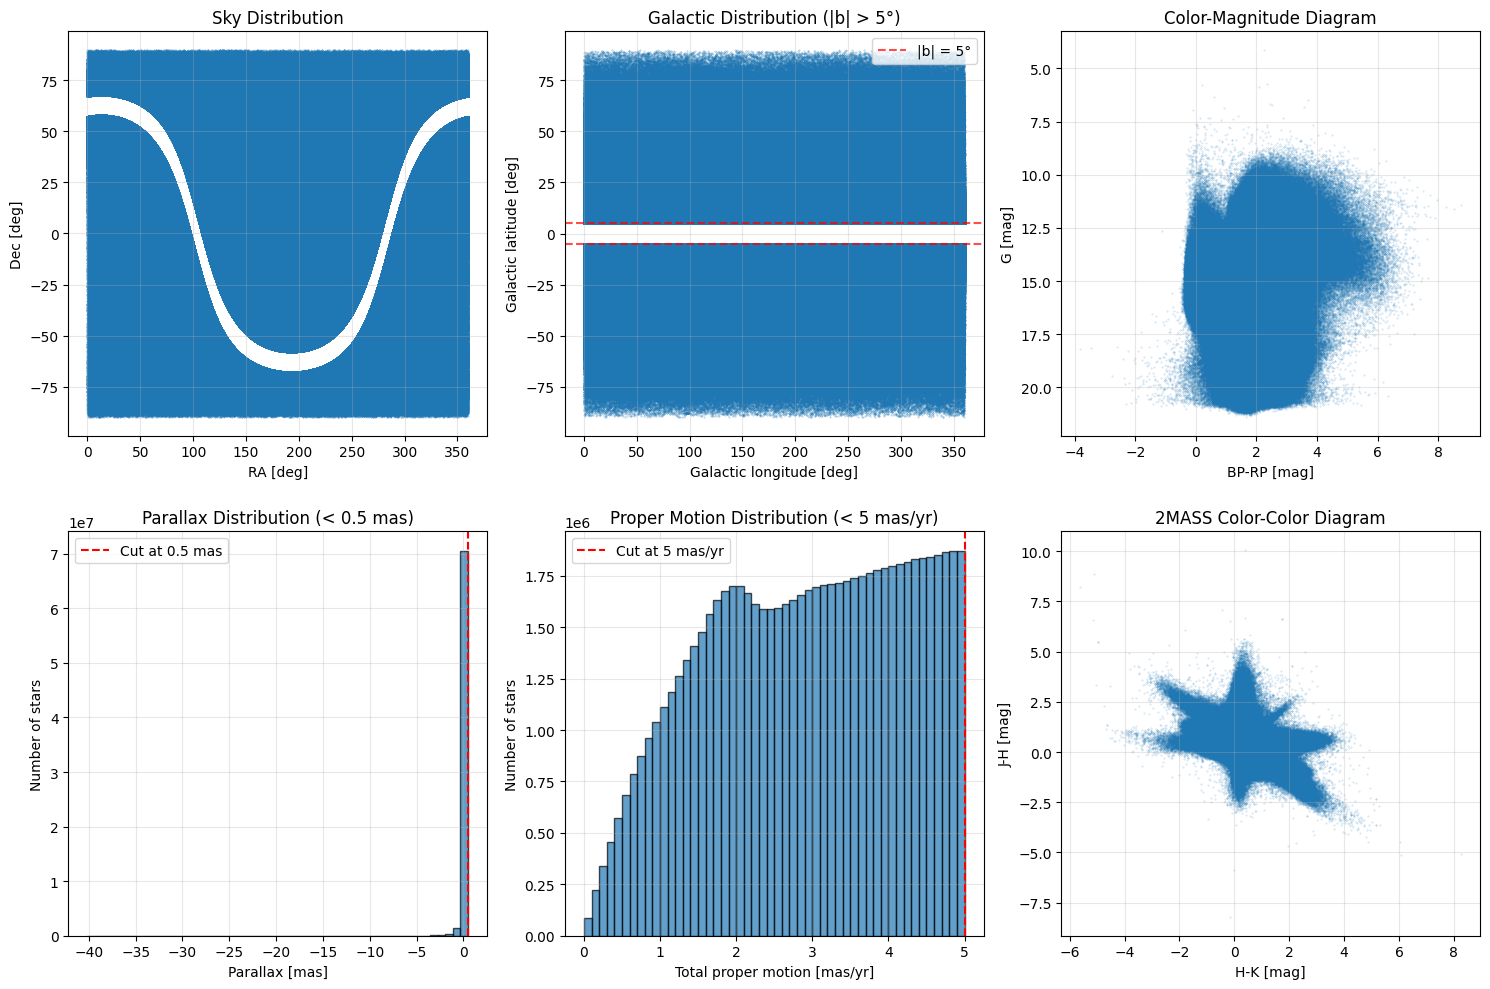

In [6]:
# Create diagnostic plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Sky distribution
axes[0,0].scatter(df['ra'], df['dec'], s=0.1, alpha=0.5)
axes[0,0].set_xlabel('RA [deg]')
axes[0,0].set_ylabel('Dec [deg]')
axes[0,0].set_title('Sky Distribution')
axes[0,0].grid(True, alpha=0.3)

# Galactic coordinates
axes[0,1].scatter(df['l'], df['b'], s=0.1, alpha=0.5)
axes[0,1].axhline(5, color='red', linestyle='--', alpha=0.7, label='|b| = 5°')
axes[0,1].axhline(-5, color='red', linestyle='--', alpha=0.7)
axes[0,1].set_xlabel('Galactic longitude [deg]')
axes[0,1].set_ylabel('Galactic latitude [deg]')
axes[0,1].set_title('Galactic Distribution (|b| > 5°)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Color-magnitude diagram
axes[0,2].scatter(df['bp_rp'], df['phot_g_mean_mag'], s=0.1, alpha=0.3)
axes[0,2].set_xlabel('BP-RP [mag]')
axes[0,2].set_ylabel('G [mag]')
axes[0,2].set_title('Color-Magnitude Diagram')
axes[0,2].invert_yaxis()
axes[0,2].grid(True, alpha=0.3)

# Parallax distribution
axes[1,0].hist(df['parallax'], bins=50, alpha=0.7, edgecolor='black')
axes[1,0].axvline(0.5, color='red', linestyle='--', label='Cut at 0.5 mas')
axes[1,0].set_xlabel('Parallax [mas]')
axes[1,0].set_ylabel('Number of stars')
axes[1,0].set_title('Parallax Distribution (< 0.5 mas)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Proper motion distribution
axes[1,1].hist(df['pm_total'], bins=50, alpha=0.7, edgecolor='black')
axes[1,1].axvline(5, color='red', linestyle='--', label='Cut at 5 mas/yr')
axes[1,1].set_xlabel('Total proper motion [mas/yr]')
axes[1,1].set_ylabel('Number of stars')
axes[1,1].set_title('Proper Motion Distribution (< 5 mas/yr)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 2MASS color-color diagram
j_h = df['j_m'] - df['h_m']
h_k = df['h_m'] - df['k_m']
axes[1,2].scatter(h_k, j_h, s=0.1, alpha=0.3)
axes[1,2].set_xlabel('H-K [mag]')
axes[1,2].set_ylabel('J-H [mag]')
axes[1,2].set_title('2MASS Color-Color Diagram')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save the data 
output_file = os.path.expanduser('~/data/gaia/low_parallax05_b5_pm5_2mass_ebv.fits')
atpy.Table.from_pandas(df).write(output_file, overwrite=True)
print(f"Saved {len(df)} stars to {output_file}")

Saved 72481320 stars to low_parallax05_b5_pm5_2mass_ebv.fits


In [38]:

# ---- thresholds (defaults); override by defining wg_params before this cell if you like ----
wg_defaults = dict(par_cut=0.25, mag_lim=(13.0, 18.5), col_lim=(1.0, 4.0), rpm_lim=(10.0, 18.0))
wg_params = wg_defaults
wg_params = dict(par_cut=0.25, mag_lim=(13.0, 20), col_lim=(1.0, 4.0), rpm_lim=(10.0, 20.0))

# ---- pull needed Gaia columns from your table (df) ----
ra   = np.asarray(df['ra'], float)
dec  = np.asarray(df['dec'], float)
par  = np.asarray(df['parallax'], float)
G    = np.asarray(df['phot_g_mean_mag'], float)
bp_rp = np.asarray(df['bp_rp'], float)
pmra = np.asarray(df['pmra'], float)
pmdec= np.asarray(df['pmdec'], float)
ebv  = np.asarray(df['ebv'], float)

# ---- extinction block (lines 78–86) ----
A0  = 3.1 * ebv
kG  = 0.9761 - 0.1704 * bp_rp
kBP = 1.1517 - 0.0871 * bp_rp
kRP = 0.6104 - 0.0170 * bp_rp
AG  = kG  * A0
ABP = kBP * A0
ARP = kRP * A0

mg  = G - AG
col = bp_rp - ABP + ARP

# ---- PM and RPM (lines 116–121) ----
pm   = np.hypot(pmra, pmdec)  # mas/yr
# Galactic latitude b
b = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs').galactic.b.to(u.rad).value
# Avoid log10(0): set non-positive PM to NaN so they drop out via 'finite'
pm_pos = np.where(pm > 0, pm, np.nan)
rpm = mg + 5.0*np.log10(pm_pos) - 1.47*np.sin(np.abs(b))

# ---- thresholds ----
par_cut            = float(wg_params['par_cut'])
mag_lo,  mag_hi    = map(float, wg_params['mag_lim'])
col_lo,  col_hi    = map(float, wg_params['col_lim'])
rpm_lo,  rpm_hi    = map(float, wg_params['rpm_lim'])

# ---- individual masks ----
wpar = par < par_cut
wmag = (mg > mag_lo)  & (mg < mag_hi)
wcol = (col > col_lo) & (col < col_hi)
wrpm = (rpm > rpm_lo) & (rpm < rpm_hi)

# ---- finite guard ----
finite = np.isfinite(par) & np.isfinite(mg) & np.isfinite(col) & np.isfinite(rpm)

# ---- WG = intersection of four masks  ----
wg_mask = wpar & wmag & wcol & wrpm & finite
wg_idx  = np.nonzero(wg_mask)[0]

print(f"wg: {wg_mask.sum():,} stars selected")
print(f"  parallax < {par_cut}")
print(f"  {mag_lo} < mg < {mag_hi}")
print(f"  {col_lo} < col < {col_hi}")
print(f"  {rpm_lo} < rpm < {rpm_hi}")

# If you want a compact subset like in the .pro, make a small record/df here:
# df_wg = df[wg_mask]

# Summary numbers (using df as your master table):
print(f"N_total={len(df):,} | N_wg={wg_mask.sum():,} | frac={wg_mask.sum()/len(df):.3%}")

wg: 8,803,145 stars selected
  parallax < 0.25
  13.0 < mg < 20.0
  1.0 < col < 4.0
  10.0 < rpm < 20.0
N_total=72,481,320 | N_wg=8,803,145 | frac=12.145%


In [39]:
# ---- distance estimation block ----

# Distance moduli for the templates (kpc -> mag)
dm_lmc = 5*np.log10(49.97e3) - 5
dm_smc = 5*np.log10(62.1e3)  - 5
dm_sgr = 5*np.log10(28.0e3)  - 5

# Template RGB loci (from the IDL)
col_nodes_lmc = np.array([0.97, 1.27, 1.5, 1.8, 2.5, 3.5])
mag_nodes_lmc = np.array([20.00, 17.30, 16.30, 15.70, 15.30, 15.40])

col_nodes_smc = np.array([0.97, 1.27, 1.5, 1.8, 2.5, 3.5])
mag_nodes_smc = np.array([19.70, 17.25, 16.40, 15.80, 15.62, 15.80])

col_nodes_sgr = np.array([0.97, 1.27, 1.5, 1.8, 2.1, 2.5, 3.5])
mag_nodes_sgr = np.array([19.50, 16.48, 15.37, 14.80, 14.60, 14.50, 14.50])

# IDL uses INTERPOL(..., /SPLINE); use CubicSpline if available, else linear
def interp_mag(col_nodes, mag_nodes, x):
    try:
        from scipy.interpolate import CubicSpline
        return CubicSpline(col_nodes, mag_nodes, extrapolate=True)(x)
    except Exception:
        return np.interp(x, col_nodes, mag_nodes)

# Apparent dereddened locus mags at each star’s colour
m_smc = interp_mag(col_nodes_smc, mag_nodes_smc, col)
m_sgr = interp_mag(col_nodes_sgr, mag_nodes_sgr, col)

# Convert locus to absolute mags via template DMs, then get mu = mg - M
mu_smc = mg - (m_smc - dm_smc)
mu_sgr = mg - (m_sgr - dm_sgr)

# IDL: dmag = 0.5*(dmag_sgr + dmag_smc)
dmag = 0.5*(mu_sgr + mu_smc)

# IDL: dist = 10^(0.2*(dmag+5))*1e-3   -> kpc
dist = 10.0**(0.2*(dmag + 5.0)) * 1e-3  # kpc


In [40]:

# Exact schema, but UPPERCASE field names to match plotting cell
dtype = np.dtype([
    ('RA',              'f8'),
    ('DEC',             'f8'),
    ('EBV',             'f8'),
    ('PMRA',            'f8'),
    ('PMDEC',           'f8'),
    ('PMRA_ERROR',      'f8'),
    ('PMDEC_ERROR',     'f8'),
    ('PHOT_G_MEAN_MAG', 'f8'),
    ('BP_RP',           'f8'),
    ('PARALLAX',        'f8'),
    ('PARALLAX_ERROR',  'f8'),
    ('DIST',            'f8'),
    ('COL',             'f8'),   # from extinction block
    ('MG',              'f8'),   # from extinction block
    ('RPM',             'f8'),   # from PM/RPM block
    ('SOURCE_ID',       'i8'),   # FITS-safe signed 64-bit
])

# WG subset only
dg = np.empty(len(wg_idx), dtype=dtype)
dg['RA']              = df['ra'             ].to_numpy(float)[wg_idx]
dg['DEC']             = df['dec'            ].to_numpy(float)[wg_idx]
dg['EBV']             = df['ebv'            ].to_numpy(float)[wg_idx]
dg['PMRA']            = df['pmra'           ].to_numpy(float)[wg_idx]
dg['PMDEC']           = df['pmdec'          ].to_numpy(float)[wg_idx]
dg['PMRA_ERROR']      = df['pmra_error'     ].to_numpy(float)[wg_idx]
dg['PMDEC_ERROR']     = df['pmdec_error'    ].to_numpy(float)[wg_idx]
dg['PHOT_G_MEAN_MAG'] = df['phot_g_mean_mag'].to_numpy(float)[wg_idx]
dg['BP_RP']           = df['bp_rp'          ].to_numpy(float)[wg_idx]
dg['PARALLAX']        = df['parallax'       ].to_numpy(float)[wg_idx]
dg['PARALLAX_ERROR']  = df['parallax_error' ].to_numpy(float)[wg_idx]
dg['DIST']            = dist.astype(float)[wg_idx]
dg['COL']             = col[wg_idx]
dg['MG']              = mg[wg_idx]
dg['RPM']             = rpm[wg_idx]
dg['SOURCE_ID']       = df['source_id'      ].to_numpy(np.int64)[wg_idx]

print(f"dg built (UPPERCASE cols): {len(dg)} rows (WG subset)")

# Save to FITS (primary + table)
out_path = os.path.expanduser('~/data/gaia/rg_gaia2mass_expanded.fits')
os.makedirs(os.path.dirname(out_path), exist_ok=True)
fits.HDUList([fits.PrimaryHDU(), fits.BinTableHDU(dg)]).writeto(out_path, overwrite=True)
print(f"Saved to {out_path}")

dg built (UPPERCASE cols): 8803145 rows (WG subset)
Saved to /Users/vasilybelokurov/data/gaia/rg_gaia2mass_expanded.fits
